**Цель проекта**: выявить закономерности, определяющие успешность игр, что позволит сделать ставку на потенциально прибыльный продукт и спланировать рекламные компании.

**План проекта**:
- Познакомится с данными (посмотреть на количество пропусков, статистические показатели и т.д.)
- Обработать данные (заполнить пропуски, удалить аномалии, добавить новые столбцы и проч.)
- Проанализировать данные (построить графики, посмотреть распределение и т.п.)
- Составить портреты регионов (установить наиболее популярные в 3 регионах платформы и жанры)
- Проверить несколько гипотез, основываясь на предоставленных данных.

**Информация о данных**

Набор данных представляет собой список выпушенных игр с 1980 по 2016 год, с названием платформы, на которой была выпущена игра. Также есть информация о том в какой год вышла игра и к какому жанру она относится. Числовые данные представлены объемами продаж (в млн) в 3 главных регионах (NA, EU, JP) и во всем остальном мире, а также оценками критиков и пользователей. Дополнительно есть информация о возрастной категории, прирсвоенной игре по оценкам ESRB.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

## Знакомство с данными

Загрузили данные и посмотрели общую информацию, проверили на наличие дубликатов один из стобцов:

In [ ]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [ ]:
data.info()
data.describe()

for name in data['Name'].unique()[:5]:
    print(data[data['Name'] == name])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
         Name Platform  Year_of_Release   Genre  NA_sales  EU_sales  JP_sales  \
0  Wii Sports      Wii           2006.0  Sports     41.36     28.96      3.77   

   Other_sales  Critic_Score User_Score Rating  
0         8.45          76.0 

Посмотрели на распределение данных по столбцам:

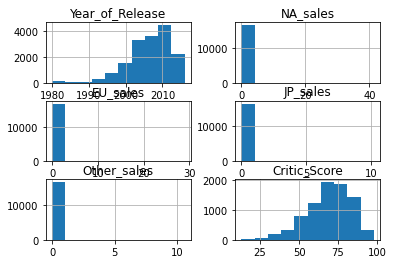

In [ ]:
data.hist()
plt.show()

**Выводы после знакомства с данными:**
- Глядя на ячейку с запросом `data.info()` можно увидеть, что в нескольких столбцах есть данные несоответсвующиего типа, например, в `user_score` тип *object*.
- В той же ячейке видно, что в наборе данных присутствует немалое количество пропусков, что тоже предстоит решить.
- Наличие дубликатов нас интересует только в столбце `name`, так как в остальных столбцах дубликаты допустимы. Проверка на дубликаты показала, что они присутсвуют, но они оправданы. Эти дубликаты являются результатом кроссплатформерности некоторых игр.
- Аномалии есть, что видно из запроса `data.decribe()`. В столбцах eu_sales и na_sales наблюдаются очень большие максимальные значения, природу которых предстоит выяснить.

## Предобработка данных

### Стандартизация названий столбцов

Заменили названия столбцов (привели к нижнему регистру):


In [ ]:
data.columns = [col.lower() for col in data.columns]
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование типов данных

Если посмотреть на игры, год релиза, которых неизвестен, можно увидеть, что в названии этих игр прописан год.
Можно подумать, что это и есть год выхода игры, однако, это не так.
Например, **'wwe Smackdown vs. Raw 2006'** вышел на самом деле в 2005 году, а **'Madden NFL 2004'** в 2003 году, поэтому заполнять пропуск в столбце `year_of_release` годом из названия нельзя.

In [ ]:
print(data.loc[data['year_of_release'].isna(), 'name'].head())

183               Madden NFL 2004
377              FIFA Soccer 2004
456    LEGO Batman: The Videogame
475    wwe Smackdown vs. Raw 2006
609                Space Invaders
Name: name, dtype: object


Преобразововать типы данных стоит в двух столбцах:

`year_of_release` - имеет тип дробный числовой, но очевидно, что год дробным быть не может, поэтому лучше привести к целочисленному типу (*int*);

`user_score` - имеет тип *object*, хотя, для этих данных гораздо лучше подходит дробный числовой тип (*float*).
По всей видимости, тип *object* поставлен ввиду наличия значения **'tbd'**, которое нужно будет убрать.
Аббревиатура 'tbd' означает, что значение будет определенно в будующем, то есть, по сути, это отсутвующие значения

Преобразовали данные в нужные типы. Заполнили пропуски в столбце с годом выхода нулями, чтобы изменить тип данных:

In [ ]:
data['year_of_release'] = data['year_of_release'].fillna(0)
data['year_of_release'] = data['year_of_release'].astype('int32')

data.loc[data['user_score'] == 'tbd', 'user_score'] = np.NaN
data['user_score'] = pd.to_numeric(data['user_score'])

### Заполнение пропусков

Нашли пропуски в данных:

In [ ]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        print(column,'\n',data[column].isna().sum())

name 
 2
genre 
 2
critic_score 
 8578
user_score 
 9125
rating 
 6766


Пропуски в столбце `year_of_release` уже были заполнены нулями для возможности привести этот столбец к типу *int*.

Пропуски в столбцах `name` и `genre` можно удалить, так как строки без значений в этих столбцах бессмысленны, а заполнить пропуски в них невозможно.

Пропуски в столбце `rating` можно заполнить частично, руководствуясь логикой. Например пазлы точно не будут иметь возрастных ограничений, так как в них исключены сцены насилия, ненормативная лексика и проч.

А вот пропуски с оценкам заполнить не представляется возможным, хоть это и количественные данные, у которых можно найти среднее и медиану. Эти показатели у каждого объекта не зависят от показателей других объектов, поэтому никакие расчёты не смогут дать достоверные значения.

Заполнили пропуски в столбцах, где это возможно, проверили, сколько строк заполнили:

In [ ]:
data = data[data['name'].notna()]

print(data['rating'].isna().sum())
data.loc[data['genre'] == 'Puzzle', 'rating'] = 'E'
print(data['rating'].isna().sum())

6764
6526


### Новый столбец (сумма продаж)

Посчитали и записали в отдельный столбец общие продажи во всех регионах


In [ ]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Исследовательский анализ данных

### Сроки появления и исчезновения различных платформ

Перед тем как определить нужный период в данных стоит расчитать сроки жизни для платформ, в которых необходимо учитывать все представленные года. В данных есть несколько линеек игровых консолей, мы взяли 3 из них: PlayStation, Xbox и Nintendo. Составили списки линеек:

In [ ]:
PS_list = []
X_list = []
DS_N_list = []

for pl in data['platform'].unique():
    if 'PS' in pl:
        PS_list.append(pl)
    elif 'X' in pl:
        X_list.append(pl)
    elif 'DS' in pl or 'N' in pl:
        DS_N_list.append(pl)

# Портативные PlayStation - параллельный продукт, принципиально отличающийся от стационарной PS, убирали из набора
PS_list = PS_list[:4]
# PCFX не относится к линейке XBox
X_list.remove('PCFX')
# GEN не относится к линейке Nintendo
DS_N_list.remove('GEN')

print(f'Платформы PlayStation: {PS_list}\n',
      f'Платформы XBox: {X_list}\n',
      f'Платформы Nintendo: {DS_N_list}\n')

Платформы PlayStation: ['PS3', 'PS2', 'PS4', 'PS']
 Платформы XBox: ['X360', 'XB', 'XOne']
 Платформы Nintendo: ['NES', 'DS', 'SNES', '3DS', 'N64', 'NG']



Написали функции для группировки и визуализации данных:


In [ ]:
def group(data):
    '''
    Функция аггрегирует игры по платформам выбранной линейки
    и находит первый и последний года выпущенных игр
    '''
    pl_years = data.pivot_table(index='platform', values='year_of_release', aggfunc=['min','max'])
    pl_years.columns = ['first_year_pl','last_year_pl']
    return pl_years

def pl_output(pl_list, data, grouped_data):
    '''
    Функция выводит текстом информацию о первом и последнем годах
    выпущенных игр на платформах выбранной линейки, а также суммарное количество лет
    После текстовой информации функция строит таблицу таймлайнов для платформы
    '''
    for pl in pl_list:
        print('Года выпуска игр на платформе:', pl, '-', \
          data.loc[data['platform'] == pl, 'year_of_release'].unique().min(), '-',\
          data.loc[data['platform'] == pl, 'year_of_release'].unique().max(),\
         '\nВсего лет выпуска игр на платформе:',\
          len(data.loc[data['platform'] == pl, 'year_of_release'].unique()), '\n')

    event = pl_list
    begin = grouped_data['first_year_pl']
    end = grouped_data['last_year_pl']
    plt.figure(figsize=(10,5))
    plt.barh(range(len(begin)), end-begin, left=begin, align='center')
    plt.yticks(range(len(begin)), event)
    plt.show()

Визуализировали данные по PlayStation:

PlayStation

Года выпуска игр на платформе: PS3 - 2006 - 2016 
Всего лет выпуска игр на платформе: 11 

Года выпуска игр на платформе: PS2 - 2000 - 2011 
Всего лет выпуска игр на платформе: 12 

Года выпуска игр на платформе: PS4 - 2013 - 2016 
Всего лет выпуска игр на платформе: 4 

Года выпуска игр на платформе: PS - 1994 - 2003 
Всего лет выпуска игр на платформе: 10 



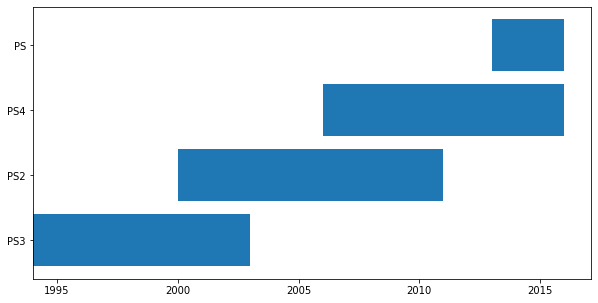

In [ ]:
data_of_PS = data.query('platform in @PS_list and year_of_release != 0')
print('PlayStation\n')

PS_grouped = group(data_of_PS)
pl_output(PS_list, data_of_PS, PS_grouped)

Визуализировали данные по XBox:

XBox

Года выпуска игр на платформе: X360 - 2005 - 2016 
Всего лет выпуска игр на платформе: 12 

Года выпуска игр на платформе: XB - 2000 - 2008 
Всего лет выпуска игр на платформе: 9 

Года выпуска игр на платформе: XOne - 2013 - 2016 
Всего лет выпуска игр на платформе: 4 



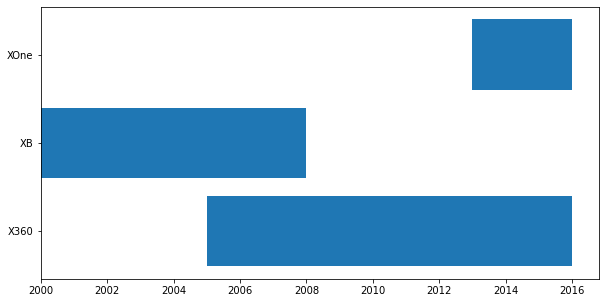

In [ ]:
data_of_X = data.query('platform in @X_list and year_of_release != 0')
print('XBox\n')

X_grouped = group(data_of_X)
pl_output(X_list, data_of_X, X_grouped)

Визуализировали данные по Nintendo:

Nintendo

Года выпуска игр на платформе: NES - 1983 - 1994 
Всего лет выпуска игр на платформе: 12 

Года выпуска игр на платформе: DS - 1985 - 2013 
Всего лет выпуска игр на платформе: 11 

Года выпуска игр на платформе: SNES - 1990 - 1999 
Всего лет выпуска игр на платформе: 10 

Года выпуска игр на платформе: 3DS - 2011 - 2016 
Всего лет выпуска игр на платформе: 6 

Года выпуска игр на платформе: N64 - 1996 - 2002 
Всего лет выпуска игр на платформе: 7 

Года выпуска игр на платформе: NG - 1993 - 1996 
Всего лет выпуска игр на платформе: 4 



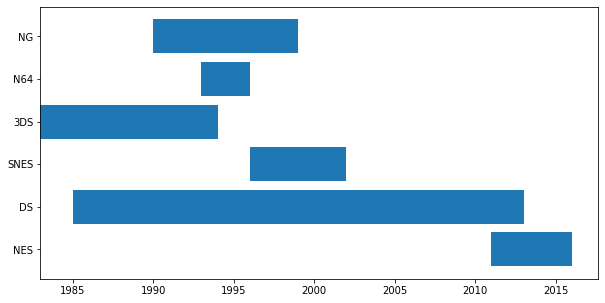

          first_year_pl  last_year_pl
platform                             
3DS                2011          2016
DS                 1985          2013
N64                1996          2002
NES                1983          1994
NG                 1993          1996
SNES               1990          1999


In [ ]:
data_of_DS_N = data.query('platform in @DS_N_list and year_of_release != 0')
print('Nintendo\n')

DS_N_grouped = group(data_of_DS_N)
pl_output(DS_N_list, data_of_DS_N, DS_N_grouped)

print(DS_N_grouped)

Игра, выпущенная на DS в 1985 году, очевидно является ошибкой в данных, устранили её:


In [ ]:
print(data.loc[(data['platform'] == 'DS')&(data['year_of_release'] == 1985)]['name'])
data = data.loc[data['name'] != 'Strongest Tokyo University Shogi DS']

15957    Strongest Tokyo University Shogi DS
Name: name, dtype: object



Средний срок выпуска игр на разных платформах (=жизни платформ) в 3 линейках (в годах):
    
    - PlayStation - 11
    - Xbox - 9
    - Nintendo - 8,6
Средний срок появления новых платформ в 3 линейках (в годах):
    
    - PlayStation - 6,3
    - Xbox - 6,5
    - Nintendo - 3,8
    
Для **Xbox** и **PlayStation** характрено меньшее количество продуктов, соответсвенно чуть больше и срок выпуска игр на их платформах, **Nintendo** же наоборот часто выпускают новые платформы, поэтому старые забываются немного быстрее.

### Количество выпущенных игр по годам

Посмотрели сколько игр было выпущено по годам


<AxesSubplot:>

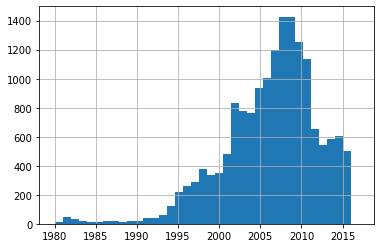

In [ ]:
data['year_of_release'].hist(bins=38, range=(1980, 2017))

По графику видно, что в первые года заданного периода выходило очень мало игр. Только начиная с 1995 года выпуск игр перевалил за порог в 200 игр/год и в последующие года ниже этого порога не падал. Соответственно все года до 1995 можно отбросить ввиду их крайне низких показателей.

Но гораздо важнее взглянуть на актуальность платформ в целом. Скорее всего найдутся такие платформы, на которых к 2016 уже давно не делают игр.

Отсекли года с малым количеством выпущенных игр и посмотрели на актуальность платформ:


In [ ]:
data = data[data['year_of_release'] > 1995]

print('Года выхода последних игр на платформах:')
for pl in data['platform'].unique():
      print(pl, '-', data.loc[data['platform'] == pl, 'year_of_release'].unique().max())

Года выхода последних игр на платформах:
Wii - 2016
GB - 2001
DS - 2013
X360 - 2016
PS3 - 2016
PS2 - 2011
GBA - 2007
PS4 - 2016
3DS - 2016
N64 - 2002
PS - 2003
XB - 2008
PC - 2016
PSP - 2015
XOne - 2016
WiiU - 2016
GC - 2007
SNES - 1999
DC - 2008
PSV - 2016
SAT - 1999
WS - 2001
NG - 1996
PCFX - 1996


Как и ожидалось, нашлось множество платформ, на которые к 2016 году перестали выпускать игры. От таких платформ стоит избавиться, так как они не помогут с прогнозом на 2017 год.

Выбрали актуальные платформы и обрезали данные по актуальности платформ:


In [ ]:
actual_platforms = []
for pl in data['platform'].unique():
    if 2016 in data.loc[data['platform'] == pl, 'year_of_release'].unique():
        actual_platforms.append(pl)
print(actual_platforms)

data = data.query('platform in @actual_platforms')

['Wii', 'X360', 'PS3', 'PS4', '3DS', 'PC', 'XOne', 'WiiU', 'PSV']


Данные за большую часть лет неактуальны. Это объясняется тем, что в настоящее время новые игры выпускают на небольшое количество новейших платформ. А статистику по старым версиям игровых платформ учитывать смысла нет, так как на них уже давно не выпускают игры.

### Продажи по платформам

Посмотрели на продажи по актуальным платформам:


<AxesSubplot:xlabel='platform'>

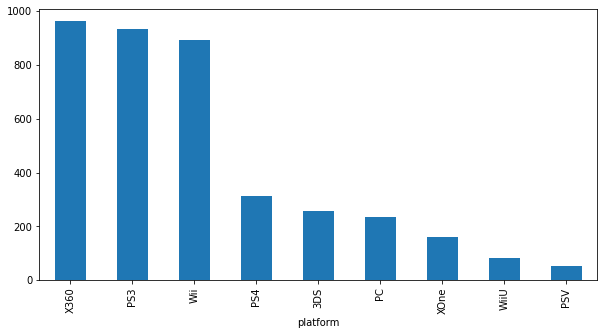

In [ ]:
platform_sales = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
platform_sales.plot(kind='bar', figsize=(10,5))

### Распределения продаж по годам для платформ

При анализе платформ по отдельности у платформы **Wii** заметен выброс в первый год работы платформы. Пик в год запуска платформы можно объяснить большим наплывам желающих попробовать новую платформу, но всё же лучше проверить в чем дело. Посмотрели на наиболее продаваемые игры:

In [ ]:
data.sort_values(by='total_sales', ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32


Действительно, у **Wii** большие успехи на рынке. Топ-3 игр именно с этой платформы. Однако, игры на втором и третьем месте были выпущены не в год запуска платформы, значит они не объясняют пик, а вот первое место имеет коллосальный отрыв от всех остальных игр.

Дело в том, что *Wii Sports* шла в наборе с самой приставкой **Wii**, из-за чего её продажи такие большие. По сути, отдельно эту игру покупали только в Японии (википедия, спасибо), а в остальных случаях она шла как часть приставки. Исходя из всего описанного лучше исключить эту игру из набора данных:

In [ ]:
data = data[data['name'] != 'Wii Sports']

График продаж по различным платформам, приведённый выше, показал, что наибольшие продажи игр были у платформ **X360**, **PS3** и **Wii**.

Однако был взят длительный период, а среди актуальных платформ есть такие, которые вышли на рынок лишь в последние годы. Чтобы ещё больше актуализировать картину, стоит обрезать данные по году выхода на рынок платформы, последней вышедшей на рынок. Нашли самою молодую платформу, посмотрев, в какой год впервые актуальные платформы были представлены на рынке все вместе:

In [ ]:
data.pivot_table(index=['year_of_release'], columns='platform', values='total_sales', aggfunc='sum').tail()

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,
2012,51.36,23.22,107.36,NaN,16.19,21.71,17.56,99.74,NaN
2013,56.57,12.38,113.25,25.99,10.59,8.59,21.65,88.58,18.96
2014,43.76,13.28,47.76,100.00,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,4.25,0.18,4.60,1.52,26.15


Обрезали таблицу по 2012 году и построили график, чтобы увидеть, какие платформы имеют большие объёмы продаж


<AxesSubplot:xlabel='year_of_release'>

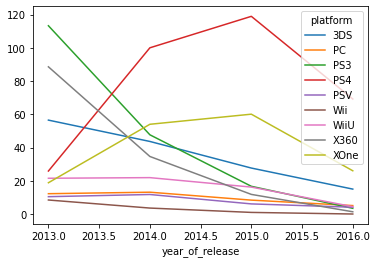

In [ ]:
ac_data = data[data['year_of_release']>2012]
dynamic_pivot = ac_data.pivot_table(index=['year_of_release'], columns='platform', values='total_sales', aggfunc='sum')
dynamic_pivot.plot(kind='line')

### Лидеры продаж

Последний график хорошо показывает лидеров рынка последних лет - **PS4**, **XOne**, **3DS**, которые и будут ***потенциально наиболее прибыльными***.
Такой результат закономерен, ведь каждая из этих платформ является последней в линейке, а соответственно наиболее желанной среди пользователей.
Однако, несмотря на популярность, даже лидеры идут на спад в последний год.
Или это неполнота данных 2016 года, как раз потому что он последний?

Посмотрели на глобальные продажи в разбивке по платформам:

<AxesSubplot:>

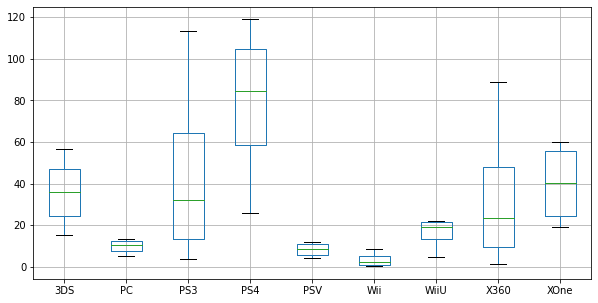

In [ ]:
dynamic_pivot.boxplot(figsize=(10,5))

Диаграмма размаха подтверждает лидерство **PS4**, **XOne**, **3DS** - их медианы расположены выше прочих.
Однако в таком виде также заметно, что **PS3** и **X360** по суммарным продажам практически не уступают лидерам.
Если просуммировать продажи за последние года, то окажется, что **PS3** даже бьёт показатели **XOne** и **3DS**.

Но не стоит забывать о динамике. С 2014 по 2016 объёмы продаж **PS3** упали более чем в ***13 раз*** (47,76/3,60), а у **XOne**, **3DS** примерно ***в 2 и 3 раза*** соответственно (54,07/26,15 и 43,76/15,14).
Таким образом потенциальная прибыльность выбранных ранее платформ остаётся выше.

In [ ]:
dynamic_pivot

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,
2013,56.57,12.38,113.25,25.99,10.59,8.59,21.65,88.58,18.96
2014,43.76,13.28,47.76,100.00,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,4.25,0.18,4.60,1.52,26.15


### Влияние отзывов пользователей и критиковна продажи
Взяли для анализа потенциально наиболее прибыльную платформу - **PS4**.
Отфильтровали данные по выбранной платформе и построили гиаграммы рассеяния для отзывов пользователей и для отзывов критиков:


<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

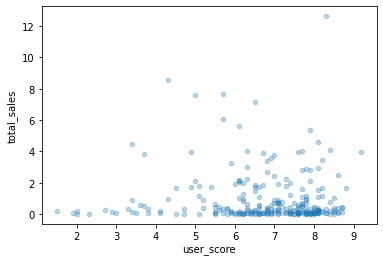

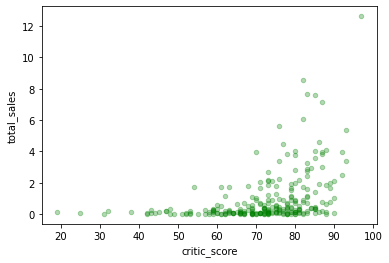

In [ ]:
data_PS4 = ac_data[ac_data['platform'] == 'PS4']

data_PS4.plot(x='user_score',y='total_sales',kind='scatter', alpha=0.3)
data_PS4.plot(x='critic_score',y='total_sales',kind='scatter', alpha=0.3, color='green')

Посчитали корреляцию отзывов пользователей и критиков с продажами:


In [ ]:
print(data_PS4['user_score'].corr(data_PS4['total_sales']).round(2))
print(data_PS4['critic_score'].corr(data_PS4['total_sales']).round(2))

-0.03
0.41


**Корреляция между оценками и объёмами продаж** существует, если речь идёт об оценке критиков, но она несильная, а если речь идёт об оценке пользователей, то можно сказать, что корреляция отсутствует.

Проверили корреляцию на других платформах:

In [ ]:
corr_list = []
for pl in actual_platforms:
    pl_sorr = []
    U_TS = ac_data.loc[ac_data['platform'] == pl,\
                      'user_score'].corr(ac_data.loc[ac_data['platform'] == pl, 'total_sales']).round(2)
    C_TS = ac_data.loc[ac_data['platform'] == pl,\
                      'critic_score'].corr(ac_data.loc[ac_data['platform'] == pl, 'total_sales'])
    if pl != 'Wii':
        C_TS = C_TS.round(2)
    pl_sorr += U_TS, C_TS
    corr_list.append(pl_sorr)

columns = ['user_score~total_sales','critic_score~total_sales']
corr_df = pd.DataFrame(corr_list, actual_platforms, columns)
corr_df

,user_score~total_sales,critic_score~total_sales
Wii,0.68,NaN
X360,-0.01,0.35
PS3,0.00,0.33
PS4,-0.03,0.41
3DS,0.24,0.36
PC,-0.09,0.20
XOne,-0.07,0.42
WiiU,0.42,0.38
PSV,0.00,0.25


Картина коррелиции сходна среди всех платформ, кроме платформ **Wii** и **WiiU**.
Например на платформе **WiiU** объемы продаж немного больше коррелируют с оценкой пользователей, чем с оценкой критиков, а на платформе **Wii** корреляция объемов продаж с оценкой пользователей сильная, и оценка критиков отсутсвует.

### Распределение игр по жанрам

Построили график общих объемов продаж и количества выпущенных игр по жанрам:

<AxesSubplot:title={'center':'Продажи и количество игр по жанрам'}, xlabel='genre'>

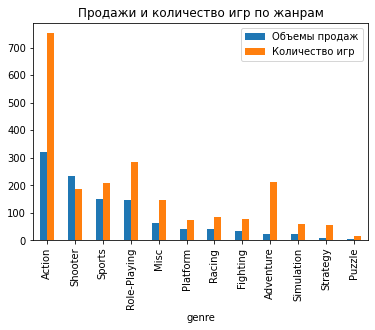

In [ ]:
genre_table = ac_data.pivot_table(index='genre',values='total_sales', aggfunc=['sum','count'])\
                    .sort_values(by=('sum','total_sales'),ascending=False)
genre_table.columns = ['Объемы продаж','Количество игр']
genre_table.plot(kind='bar',title='Продажи и количество игр по жанрам')

Посчитали и посмотрели на объемы продаж на 1 игру в каждом жанре:

<AxesSubplot:title={'center':'Среднее и медиана объемов продаж на 1 игру по жанрам'}, xlabel='genre'>

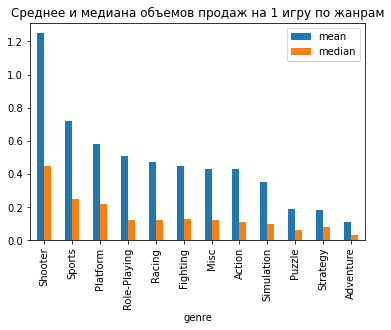

In [ ]:
genre_mean_median = []
for genre in data['genre'].unique():
    cur_list = []
    cur_list.append(genre)
    cur_mean = ac_data.loc[ac_data['genre'] == genre, 'total_sales'].mean().round(2)
    cur_list.append(cur_mean)
    cur_median = ac_data.loc[ac_data['genre'] == genre, 'total_sales'].median().round(2)
    cur_list.append(cur_median)
    genre_mean_median.append(cur_list)
from operator import itemgetter
genre_mean_median = sorted(genre_mean_median, key=itemgetter(1), reverse=True)

columns = ['genre','mean', 'median']
index = range(12)
df_mean_median = pd.DataFrame(genre_mean_median, index, columns)

df_mean_median.plot(x='genre', kind='bar',title='Среднее и медиана объемов продаж на 1 игру по жанрам')

Самые прибыльные жанры по общим объемам продаж: **Action, Shooter, Sports** и **Role-playing**, однако соотношение объемов продаж к количеству вышедших игр у этих жанров разное.
Точнее это соотношение можно увидеть на графиках отображающих среднее и медиану по объемам продаж на 1 игру в жанре.

У жанра **Action**, не смотря на совокупно наибольшую выручку, весьма низкие показатели объемов продаж на 1 игру: в среднем 0.43 млн продаж на игру, а медианное значение 0.11 млн. По всей видимости, большого совокупного объёма выручки этому жанру удаётся достигать большим количеством выпускаемых игр.

***Наиболее прибыльные*** игры относятся к жанру **Shooter**. Только у этого жанра среднее значение объемов продаж превосходит 1 млн, а медиана почти достигает 0,5 млн. Вместе с этим по количеству выпускаемых игр **Shooter** лишь на 5-ом месте.

Жанры **Sports** и **Platform** также представляются ***прибыльными***, так как они занимают 2 и 3 места по показателям среднего и медианны объемов продаж.

***Наименее прибыльными*** являются жанры **Adventure, Strategy, Puzzle**. Интересно, что не смотря на это, жанр **Adventure** занимает третье место по количеству выпускаемых игр.

## Портреты регионов

### Наиболее популярные платформы в каждом регионе

Написали функцию для расчёта объёмов и доли продаж топ-5 категорий по какому-либо параметру в регионе:

In [ ]:
def reg_data(reg_name, data, index):
    '''
    Функция аггрегирует суммы категорий какого-либо параметра в заданном регионе
    reg_name - название региона двумя строчными латинскими буквами
    data - обрабатываемый датасет
    index - параметр, по которому будет происходить аггрегация категорий
    '''
    reg_data = data.pivot_table(index=f'{index}',values=f'{reg_name}_sales',aggfunc='sum')\
            .sort_values(by=f'{reg_name}_sales',ascending=False)\
            .head(5)
    reg_data['part, %'] = (reg_data[f'{reg_name}_sales']/data[f'{reg_name}_sales'].sum()).round(4)*100
    reg_data.loc['Other'] = [(data[f'{reg_name}_sales'].sum() - reg_data[f'{reg_name}_sales'].sum()),\
                            100 - reg_data['part, %'].sum()]
    return reg_data

Применили функцию к каждому региону для расчёт топ-5 платформ:


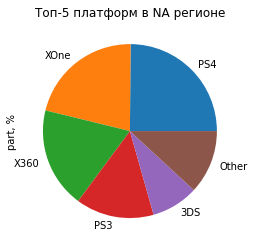

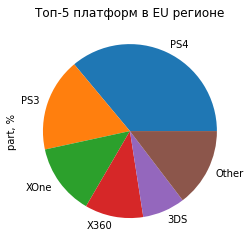

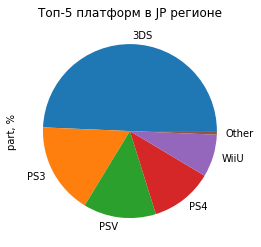

In [ ]:
na_pl_data = reg_data('na', ac_data, 'platform')
eu_pl_data = reg_data('eu', ac_data, 'platform')
jp_pl_data = reg_data('jp', ac_data, 'platform')

na_pl_data['part, %'].plot(kind='pie',title='Топ-5 платформ в NA регионе')
plt.show()
eu_pl_data['part, %'].plot(kind='pie',title='Топ-5 платформ в EU регионе')
plt.show()
jp_pl_data['part, %'].plot(kind='pie',title='Топ-5 платформ в JP регионе')
plt.show()

В топ-5 самых популярных платформ в NA первое и второе место занимают **PS4** и **XOne**, причем разрыв между ними небольшой. Оба лидера занимают почти по четверти рынка. Далее, на третьем и четвертом месте идут предыдущие версии платформ этих же линеек **PS3** и **XBox360**, только теперь продук XBox обгоняет PS, впрочем снова с небольшим разрывом. На пятом месте находится **3DS**. Доля рынка, занимаемого продуктами XBox составляет 40%.

В EU регионе распределение по платформам менее равномерное: на первом месте идет **PS4** с отрывом более, чем в 2 раза от второго места, на котором, находиться предыдущая версия PS - **PS3**. Вместе **PS4** и **PS3** занимают больше половины рынка. Третье и четвертое место занимают **XOne** и **XBox360**, а на пятом снова расположился **3DS**, хотя их доли на рынке отличаются незначительно.

В JP регионе картина популярности платформ разительно отличается от предыдущих регионов. Первое место с почти трёхкратным отрывом от второго места занимает **3DS**, который был на последнем месте в NA и EU. Доля **3DS** составляет почти половину всего рынка. Далее на втором, третьем и четвертом месте идут продукты от PS, которые вместе забирают почти всю остальную половину рынка. На пятом месте расположилась **WiiU**, заняв 8% рынка. Продуктов XBox практически нет. Доля остальных платформ в регионе менее 1%.

### Наиболее популярные жанры в каждом регионе

Применили написанную ранее функцию к каждому региону для расчёта топ-5 жанров:


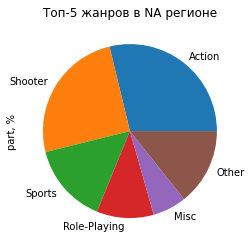

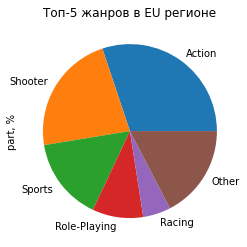

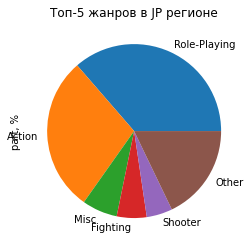

In [ ]:
na_gen_data = reg_data('na', ac_data, 'genre')
eu_gen_data = reg_data('eu', ac_data, 'genre')
jp_gen_data = reg_data('jp', ac_data, 'genre')

na_gen_data['part, %'].plot(kind='pie',title='Топ-5 жанров в NA регионе')
plt.show()
eu_gen_data['part, %'].plot(kind='pie',title='Топ-5 жанров в EU регионе')
plt.show()
jp_gen_data['part, %'].plot(kind='pie',title='Топ-5 жанров в JP регионе')
plt.show()

Распределение топ-5 самых популярных жанров в NA и EU регионе очень похожи. И там и там первые 4 места, причем в одинаковом порядке занимают **Action, Shooter, Sports** и **Role-Playing**. Первые два жанра занимаю по одной четверти рынка в NA, а в EU разрыв чуть больше: 30.1% против 22.5%. **Sports** и **Role-Playing** занимают примерно по 15% и 10% соответственно. Лишь на пятом месте стоят разные жанры: в NA **Misc**, а в EU **Racing**. Что удивительно распределение по долям у топ-5 жанров в обоих регионах также очень похоже, хотя в распределении платформ, которые было показано в предыдущем пункте, различия были существенные.

В JP регионе картина снова отличается от предыдущих регионов. Первое место занимает **Role-Playing**, забрав себе более трети всего рынка. На втором месте расположился жанр **Action** (похоже этот жанр пользуется популярностью по всему свету), на его долю пришлось более четверти рынка. Жанры **Misc, Fighting, Shooter** забрали себе с третьего по пятое места, каждый из них занимает менее 7% рынка.

### Влияние рейтинга ESRB на продажи в каждом регионе

Применили написанную ранее функцию к каждому региону для расчёта долей возрастных рейтингов


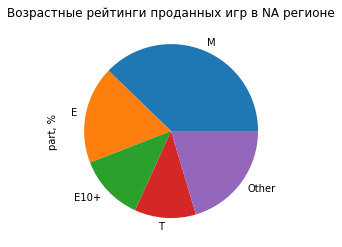

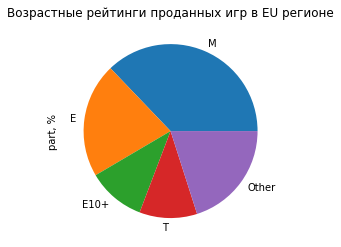

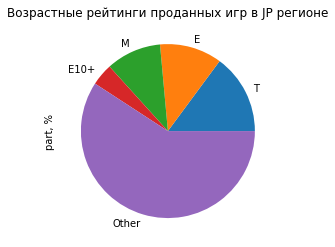

In [ ]:

na_r_data = reg_data('na', ac_data, 'rating')
eu_r_data = reg_data('eu', ac_data, 'rating')
jp_r_data = reg_data('jp', ac_data, 'rating')

na_r_data['part, %'].plot(kind='pie',title='Возрастные рейтинги проданных игр в NA регионе')
plt.show()
eu_r_data['part, %'].plot(kind='pie',title='Возрастные рейтинги проданных игр в EU регионе')
plt.show()
jp_r_data['part, %'].plot(kind='pie',title='Возрастные рейтинги проданных игр в JP регионе')
plt.show()

И снова распределение данных в NA и EU регионах очень похожи. Влияние рейтинга ESRB на продажи сходится почти абсолютно. Лучше всего продаются игры категории **M**, на их долю приходится более трети рынка. Приблизительно 20% проданных игр относятся к категории **Е** и чуть более 10% рынка занимают категории **Е10+** и **Т** каждая. Остальные категории игр занимают пятую часть рынка.

В JP категории **M** занимает лишь десятую часть рынка. Категория **Т** заняла 14.9%, категория **Е** 11.6%, а категория **Е10+** 4.1%. На остальные возрастные категории приходится 59.2% рынка, что говорит о том, что в JP регионе возрастной рейтинг имеет слабое влияние на объемы продаж игр.

Однако для подтверждения влияния возрастных рейтингов на объем продаж следует провести математический анализ показателей, а именно посчитать корреляцию:

In [ ]:
ac_rating_data = ac_data[ac_data['rating'].notna()]
for rate in ac_rating_data['rating'].unique():
    if rate == 'E':
        ac_rating_data.loc[ac_data['rating'] == rate, 'rating_id'] = 1
    elif rate == 'E10+':
        ac_rating_data.loc[ac_data['rating'] == rate, 'rating_id'] = 2
    elif rate == 'T':
        ac_rating_data.loc[ac_data['rating'] == rate, 'rating_id'] = 3
    elif rate == 'M':
        ac_rating_data.loc[ac_data['rating'] == rate,'rating_id'] = 4
    else:
        ac_data.loc[ac_data['rating'] == rate, 'rating_id'] = 0

rating_data = ac_rating_data[['na_sales','eu_sales','jp_sales','rating_id']]
rating_data.corr()

,na_sales,eu_sales,jp_sales,rating_id
na_sales,1.000000,0.717169,0.236568,0.103468
eu_sales,0.717169,1.000000,0.269564,0.068926
jp_sales,0.236568,0.269564,1.000000,-0.006704
rating_id,0.103468,0.068926,-0.006704,1.000000


Не смотря не то, что на гистограммах явно выраженна неравномерность распределения продаж по возрастным категориям в двух регионах, коэффициент корреляции между объёмами продажам и возрастной категорией очень близок к нулю во всех регионах, что говорит о том, что линейной зависимости между этими показателясми нету.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

-- эту формулировку возьмём для Нуль-гипотезы, т.к. для неё стоит брать высказывания, в которых можно использовать знак равенства, Альтернативная гипотеза противоположна: средние пользовательские рейтинги платформ Xbox OQne и PC разные

В нашем случае мы сравниваем средние у двух независимых выборок между собой, поэтому можно использовать предназначенный T-тест для средних двух независимых выборок - `scipy.stats.ttest_ind()`. Параметр `equal_var` стоит задать как `True`, так как выборки взяты из схожих по параметрам совокупностей.

In [ ]:
# Создали необходимые выборки
XOne = ac_data[ac_data['platform']=='XOne']['user_score'].dropna()
PC = ac_data[ac_data['platform']=='PC']['user_score'].dropna()

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

# Проверили верность нуль-гипотезы
results = st.ttest_ind(XOne, PC, equal_var=True)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу\n\n',
          'Результат: Средние пользовательские рейтинги платформ Xbox OQne и PC разные.')
else:
    print('Не получилось отвергнуть нулевую гипотезу\n\n',
          'Результат: Средние пользовательские рейтинги платформ Xbox OQne и PC одинаковые.')

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу

 Результат: Средние пользовательские рейтинги платформ Xbox OQne и PC одинаковые.


### Средние пользовательские рейтинги жанров Action и Sports разные.

-- эту формулировку удобно взять для Альтернативнной-гипотезы, т.к. в этом высказывании утверждается неравенство, тогда Нуль-гипотеза гипотеза противоположна: средние пользовательские рейтинги рейтинги жанров Action и Sports одинаковые.

Ситуация аналогична предыдущей проверке, поэтому использовали здесь тот же метод `scipy.stats.ttest_ind()`.

In [ ]:
# Создали необходимые выборки
Action = ac_data[ac_data['genre']=='Action']['user_score'].dropna()
Sports = ac_data[ac_data['genre']=='Sports']['user_score'].dropna()

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

# Проверили верность нуль-гипотезы
results = st.ttest_ind(Action, Sports, equal_var=True)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу\n\n',
          'Результат: Средние пользовательские рейтинги рейтинги жанров Action и Sports разные')
else:
    print('Не получилось отвергнуть нулевую гипотезу\n\n',
          'Результат: Средние пользовательские рейтинги рейтинги жанров Action и Sports одинаковые')

p-значение: 1.8791962987532298e-27
Отвергаем нулевую гипотезу

 Результат: Средние пользовательские рейтинги рейтинги жанров Action и Sports разные


## Общий вывод

### Предобработка данных

- Заменили названия всех столбцов, приведя их к нижнему регистру
- Преобразовали типы данных в столбцах в более подходящие:
    - `year_of_release` привели к целочисленному типу
    - `user_score` привели к дробному числовому
- Обработали значение 'tbd' в столбце 'user_score', заменили его на эквивалент (NaN)
(Аббревиатура 'tbd' означает, что значение будет определенно в будующем, то есть, по сути, это отсутвующие значения)
- Нашли проспуски в данных и заполнили их, там где это было возможно:
    - удалили строки с пропусками в столбцах `name` и `genre`
    - в столбце `rating` для игр жанра **Puzzle** заполнили пропуски значением *'E'*
(Пропуски с оценкам пользователей и критиков заполнить не представляется возможным. Эти показатели у каждого объекта не зависят от показателей других объектов, поэтому никакие расчёты не смогут дать достоверные значения.)
- Посчитали суммарные продажи во всех регионах и вставили полученные значения в новый столбец    

### Исследовательский анализ
- Установили характерные сроки появления новых и ухода старых платформ на примере трёх линеек игрофых платформ.  
    - PlayStation: средний срок ухода платформы - 11 лет, средний срок появления новой платформы - 6.3 года.
    - XBox: средний срок ухода платформы - 9 лет, средний срок появления новой платформы - 6.5 года.
    - Nintendo: средний срок ухода платформы - 8.6 лет, средний срок появления новой платформы - 3.8 года.
    **Nintendo** чаще выпускают новые платформы, по сравнению с XBox и PlayStation, поэтому старые забываются немного быстрее.
- Исследовали сколько игр выпускалось в разные годы:
    - В качестве наиболее актуальных данных были выбраны 2013-2016 года, так как в 2013 вышла на рынок последняя актуальная игровая платформа.
- Исследовали как менялись продажи по платформам за актуальный период:
    - Продажи всех платформ пошли на спад последний 2016 год, но лидеры 2015-ого года сохранили свои позиции. Среди этих лидеров были такие платформы как **PS4, XOne, 3DS**, они же являются потенциально наиболее прибыльными платформами.
- Исследовали глобальные продажи по всем актуальным платформам с помощью диаграммы размаха:
    - Установили, что **PS3** и **X360** по суммарным продажам практически не уступают лидерам. Это объясняется тем, что до выхода новых платформ в своих линейках предыдущие версии занимали лидирующие позиции. Однако, как уже отмечалось ранее, текущая ситуация показывает, что новейшие платформы имеют наибольшую популярность.
- Исследовали влияние оценки пользователей и критиков на продажи внутри платформы **PS4**:
    - оценки пользователей не влияют на объемы продаж
    - оценки критиков слабо влиют на объемы продаж
- Исследовали влияние оценки пользователей и критиков среди остальных платформ:
     - Картина коррелиции сходна среди всех платформ, кроме платформ **Wii** и **WiiU**.
     - На платформе **WiiU** объемы продаж больше коррелируют с оценкой пользователей, чем с оценкой критиков, а на платформе **Wii** корреляция объемов продаж с оценкой пользователей сильная, и оценка критиков отсутсвует.
- Изучено распределение игр по жанрам:
    - Самые прибыльные жанры по общим объемам продаж: **Action, Shooter, Sports** и **Role-playing**
    - У жанра **Action**, не смотря на совокупно наибольшую выручку, весьма низкие показатели объемов продаж на 1 игру: в среднем 0.43 млн продаж на игру, а медианное значение 0.11 млн. По всей видимости, большого совокупного объёма выручки этому жанру удаётся достигать большим количеством выпускаемых игр.
    - ***Наиболее прибыльные*** игры относятся к жанру **Shooter**. Только у этого жанра среднее значение объемов продаж превосходит 1 млн, а медиана почти достигает 0,5 млн.
    - ***Наименее прибыльными*** являются жанры **Adventure, Strategy, Puzzle**. Интересно, что не смотря на это, жанр **Adventure** занимает третье место по количеству выпускаемых игр.

### Портреты регионов
- Определили топ-5 платформ в каждом регионе(доли в % от объема общих продаж):
    - NA: 1.**PS4**-24.88%, 2.**XOne**-21.30%, 3.**XBox360**-18.68%, 4.**PS3**-14.53%, 5.**3DS**-8.74%, остальные платформы-11.87%.
    - EU: 1.**PS4**-36.07%, 2.**PS3**-17.33%, 3.**XOne**-13.19%, 4.**XBox360**-10.87%, 5.**3DS**-7.91%, остальные платформы-14.63%.
    - JP: 1.**3DS**-49.32%, 2.**PS3**-16.98%, 3.**PSV**-13.52%, 4.**PS4**-11.61%, 5.**WiiU**-7.91%, остальные платформы-0.66%.
     
- Определили топ-5 жанров в каждом регионе(доли в % от объема общих продаж):
    - NA: 1.**Action**-28.78%, 2.**Shooter**-25.10%, 3.**Sports**-14.93%, 4.**Role-Playing**-10.61%, 5.**Misc**-6.28%, остальные жанры-14.93%.
    - EU: 1.**Action**-30.13%, 2.**Shooter**-22.46%, 3.**Sports**-15.42%, 4.**Role-Playing**-9.45%, 5.**Racing**-5.16%, остальные жанры-17.38%.
    - JP: 1.**Role-Playing**-36.37%, 2.**Action**-28.84%, 3.**Misc**-6.57%, 4.**Fighting**-5.55%, 5.**Shooter**-4.81%, остальные жанры-17.86%.

- Изучение влияния возрастного рейтинга на продажи:
    - Установили распределение объемово продаж по возрастным категориям в двух регионах:
        
        - NA: 1.**M**-37.79%, 2.**E**-18.11%, 3.**E10+**-12.32%, 4.**T**-11.39%, остальные жанры-20.39%.
        - EU: 1.**M**-37.15%, 2.**E**-21.32%, 3.**E10+**-10.74%, 4.**T**-10.72%, остальные жанры-20.07%.
        - JP: 1.**T**-14.87%, 2.**E**-11.58%, 3.**M**-10.26%, 4.**E10+**-4.10%, остальные жанры-59.19%.
        
    - Несмотря на явную неравномерность по проведённым расчётам можно сказать, что линейной зависимости между этими показателями нету, так как коэффициент корреляции очень мал во всех случаях: 0.103468, 0.068926, -0.006704.
      
### Проверка гипотез
Проверили две гипотезы:

 - **Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

Результат: p-value = 0.14012658403611647, поэтому Нуль-гипотезу отвергнуть не получилось, мы её приняли:

***Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.***

 - **Средние пользовательские рейтинги жанров Action и Sports одинаковые**

Результат: p-value = 1.8791962987532298e-27, поэтому отвергли Нуль-гипотезу, приняли Альтернативную гипотезу:

***Средние пользовательские рейтинги жанров Action и Sports разные.***

Для проверки гипотез в обоих случаях использовали Т-тест для сравнения средних двух независимых выборок, так как необходимо было сравнить две выборки друг с другом и они были независимы друг от друга